In [1]:
!pip install langgraph langchain langchain-community langchain-openai python-dotenv -q


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
#from google.colab import userdata
import requests
from typing import List, Literal
from langchain_openai import ChatOpenAI

In [3]:
# 3fd203f425a25a0bfd6:2d87b2b
!pip install arize-phoenix-otel -q
PHOENIX_CLIENT_HEADERS='api_key=3fd203f425a25a0bfd6:2d87b2b'
PHOENIX_COLLECTOR_ENDPOINT='https://app.phoenix.arize.com'


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
from phoenix.otel import register

# Add Phoenix API Key for tracing
PHOENIX_API_KEY = "3fd203f425a25a0bfd6:2d87b2b"
os.environ["PHOENIX_CLIENT_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com"

# configure the Phoenix tracer
tracer_provider = register(
  project_name="my-travel-advisor-app", # Default is 'default'
) 

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: my-travel-advisor-app
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {'api_key': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [5]:
!pip install openinference-instrumentation-langchain -q


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
from openinference.instrumentation.langchain import LangChainInstrumentor
LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

In [7]:
from langchain_core.tools import tool
import requests

# Define tools
@tool
def suggest_destination(preference: str) -> str:
    """
    Suggest a travel destination based on the user's preference.
    Supported preferences: 'beach', 'mountains', 'city'.
    """
    destinations = {
        "beach": ["Maldives", "Hawaii", "Bali"],
        "mountains": ["Swiss Alps", "Himalayas", "Rockies"],
        "city": ["New York", "Paris", "Tokyo"]
    }
    if preference.lower() in destinations:
        return f"Recommended destinations for {preference}: {', '.join(destinations[preference.lower()])}."
    return "Unknown Preference"

@tool
def calculate_cost(destination: str) -> str:
    """
    Calculate the estimated travel cost for a destination.
    Returns cost in USD.
    """
    costs = {
        "Maldives": 2000,
        "Hawaii": 2500,
        "Bali": 1800,
        "Swiss Alps": 3000,
        "Himalayas": 1500,
        "Rockies": 2200,
        "New York": 1500,
        "Paris": 2800,
        "Tokyo": 3200
    }
    if destination in costs:
        return f"The estimated cost for traveling to {destination} is ${costs[destination]}."
    return f"Cost data not available for {destination}."

@tool
def check_weather(destination: str) -> str:
    """
    Check the current weather for a destination using OpenWeatherMap API.
    """
    api_key = "0675471b02560f1584b3a672bc92938f"  # Replace with your actual API key
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    
    params = {
        "q": destination,
        "appid": api_key,
        "units": "metric"
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        weather_data = response.json()
        
        temperature = weather_data["main"]["temp"]
        description = weather_data["weather"][0]["description"]
        
        return f"The current weather in {destination} is {description} with a temperature of {temperature}°C."
    except requests.RequestException:
        return f"Unable to retrieve weather information for {destination}."


In [ ]:
def get_openai_api_key():
    """Get OpenAI API key from environment variables."""
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise ValueError("OPENAI_API_KEY not found in environment variables")
    return api_key

In [ ]:
# Add tools to a ToolNode
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

tools = [suggest_destination, calculate_cost, check_weather]
tool_node = ToolNode(tools)

# Define functions for LLM and tools
from langchain_openai import ChatOpenAI

def call_model(state: MessagesState):
    messages = state["messages"]
    llm = ChatOpenAI(model="gpt-4o-mini", api_key=get_openai_api_key(), temperature=0)
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

# Workflow setup
workflow = StateGraph(MessagesState)

workflow.add_node("LLM", call_model)
workflow.add_edge(START, "LLM")
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges("LLM", call_tools)
workflow.add_edge("tools", "LLM")

agent = workflow.compile()

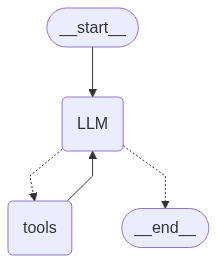

In [9]:
# Generate and display Mermaid diagram
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, NodeStyles

node_styles = NodeStyles(
    default="#fad7de",  # This will be used for most nodes
    first="#ffdfba",    # Color for the start node
    last="#baffc9"      # Color for the end node
)

mermaid_png = agent.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    node_colors=node_styles,
    wrap_label_n_words=9,
    background_color="white",
    padding=10
)

display(Image(mermaid_png))

In [10]:
for chunk in agent.stream(
    {"messages": [("user", "My budget is 2000 and I love cities. Suggest me a travel plan with atleast 2 destinations and include current weather")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

Transient error Service Unavailable encountered while exporting span batch, retrying in 1s.
Transient error Service Unavailable encountered while exporting span batch, retrying in 2s.
Transient error Service Unavailable encountered while exporting span batch, retrying in 4s.
Transient error Service Unavailable encountered while exporting span batch, retrying in 8s.
Transient error Service Unavailable encountered while exporting span batch, retrying in 16s.


================================ Human Message =================================

My budget is 2000 and I love cities. Suggest me a travel plan with atleast 2 destinations and include current weather
================================== Ai Message ==================================
Tool Calls:
  suggest_destination (call_2XzLgZSZRq7BUUV30ab8iO2U)
 Call ID: call_2XzLgZSZRq7BUUV30ab8iO2U
  Args:
    preference: city
================================= Tool Message =================================
Name: suggest_destination

Recommended destinations for city: New York, Paris, Tokyo.
================================== Ai Message ==================================
Tool Calls:
  calculate_cost (call_4GnZDVdP6Tom3G0XhUM3zud9)
 Call ID: call_4GnZDVdP6Tom3G0XhUM3zud9
  Args:
    destination: New York
  calculate_cost (call_ZDIptSjuOsnrl1ORnBPRtTFm)
 Call ID: call_ZDIptSjuOsnrl1ORnBPRtTFm
  Args:
    destination: Paris
  check_weather (call_nZLcLNWbpfcVJbNAFhJrtpn2)
 Call ID: call_nZLcLNWbpfcVJbNAFh